In [1]:
%autosave 0
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

Autosave disabled


In [2]:
# Store filepaths in variables.
file_metro_medvalue = "../Datasets/Affordability_ChainedZHVI_2018Q4.csv"
file_metro_medHHinc = "../Datasets/Affordability_Income_2018Q4.csv"
file_metro_crosswlk = "../Datasets/CountyCrossWalk_Zillow.csv"
file_census_pop = "../Datasets/PEP_2017_GCTPEPANNR.US23PR.csv"

In [3]:
# Read our Data file with the pandas library, and create dataframes.
# The Zillow CSV files require ISO-8859-1 encoding.
medvalue_df = pd.read_csv(file_metro_medvalue, encoding="ISO-8859-1") # Zillow Home Value Index (ZHVI)
medHHinc_df = pd.read_csv(file_metro_medHHinc, encoding="ISO-8859-1") # Median Household (HH) Income
crosswlk_df = pd.read_csv(file_metro_crosswlk, encoding="ISO-8859-1") # Crosswalk of Zillow MSA name to Census Bureau code
censuspop_df = pd.read_csv(file_census_pop, encoding="ISO-8859-1") # US Census Bureau population estimates by MSA

In [4]:
# Preparing the Home Value dataframe.
medvalue_10yr_df = medvalue_df[["RegionID", "RegionName", "SizeRank", "2008-12", "2018-12"]]
medvalue_10yr_df = medvalue_10yr_df.set_index("RegionID")
medvalue_10yr_df = medvalue_10yr_df.rename(columns={"RegionName" : "Metro Name",
                                                    "SizeRank" : "Metro Rank",
                                                    "2008-12" : "2008-Q4 Home Value",
                                                    "2018-12" : "2018-Q4 Home Value"
                                                   })
medvalue_10yr_df = medvalue_10yr_df.dropna(how="any")

medvalue_10yr_df["10-Yr Home Value Chg"] = (medvalue_10yr_df.iloc[:,3] - medvalue_10yr_df.iloc[:,2]) / \
                                           medvalue_10yr_df.iloc[:,2]

In [5]:
# Preparing the Median Household Income dataframe.
medHHinc_10yr_df = medHHinc_df[["RegionID", "RegionName", "SizeRank", "2008-12", "2018-12"]]
medHHinc_10yr_df = medHHinc_10yr_df.set_index("RegionID")
medHHinc_10yr_df = medHHinc_10yr_df.rename(columns={"RegionName" : "Metro Name",
                                                    "SizeRank" : "Metro Rank",
                                                    "2008-12" : "2008-Q4 HH Income",
                                                    "2018-12" : "2018-Q4 HH Income"
                                                   })
medHHinc_10yr_df = medHHinc_10yr_df.dropna(how="any")

medHHinc_10yr_df["10-Yr HH Income Chg"] = (medHHinc_10yr_df.iloc[:,3] - medHHinc_10yr_df.iloc[:,2]) / \
                                           medHHinc_10yr_df.iloc[:,2]

In [6]:
# Join both datasets
metro_10yr_df = pd.merge(medvalue_10yr_df, medHHinc_10yr_df, on="RegionID")
metro_10yr_df = metro_10yr_df.drop(columns=["Metro Name_y", 'Metro Rank_y'])
metro_10yr_df = metro_10yr_df.rename(columns={"Metro Name_x" : "Metro Name",
                                              "Metro Rank_x" : "Metro Rank"
                                             })
metro_10yr_df["10-Yr Home Value Chg"] *= 100
metro_10yr_df["10-Yr HH Income Chg"] *= 100

In [7]:
# Preparing the crosswalk dataframe, population dataframe,
# and join them both.
cross_walk_df = crosswlk_df[["MetroRegionID_Zillow", "CBSACode"]]
cross_walk_df = cross_walk_df.rename(columns={"MetroRegionID_Zillow" : "RegionID",
                                              "CBSACode": "Metro Code"
                                             })
population_df = censuspop_df[["GC.target-geo-id2", "respop72017"]]
population_df = population_df.rename(columns={"GC.target-geo-id2" : "Metro Code",
                                              "respop72017": "Population"
                                             })
metro_pop_df = pd.merge(cross_walk_df, population_df, on="Metro Code")
metro_pop_df = metro_pop_df.dropna(how="any")
metro_pop_df = metro_pop_df.drop_duplicates(keep="first").reset_index(drop=True)
metro_pop_df["RegionID"] = metro_pop_df.RegionID.astype(int)
metro_pop_df = metro_pop_df.set_index("RegionID")

In [8]:
# Join population counts to the combined income and home value dataframe
metro_main_df = pd.merge(metro_10yr_df, metro_pop_df, on="RegionID", how="left")
metro_main_df = metro_main_df.drop(columns=["Metro Code"])

# The US as a whole is not an MSA, so it doesn't have a metro code.  
# All datasets place the US in the first row so copy the population with a loc reference.
metro_main_df.loc[102001, "Population"] = population_df.loc[0,"Population"]

In [9]:
# Remove United States row (not a Metro) from the Metro dataframe

# First store value US values into a list
# We can use these values later for a comparison
# Using iloc ---> US_data = metro_10yr_df.iloc[0, :]
US_data = metro_main_df.loc[102001, :]

# Metro dataframe will include only the metros
# Using iloc ---> metro_10yr_df = metro_10yr_df.iloc[1: , :]
metro_main_df = metro_main_df.loc[394913: , :]

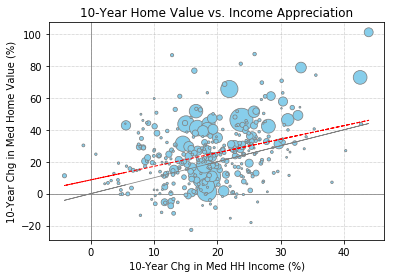

In [10]:
# Create scatterplot
income_chg = metro_main_df["10-Yr HH Income Chg"]
value_chg = metro_main_df["10-Yr Home Value Chg"]

plt.scatter(income_chg, value_chg, marker="o", facecolor="skyblue", edgecolor="grey",
            linewidth=0.75, zorder=2, s=metro_main_df["Population"]/25000)
plt.xlabel("10-Year Chg in Med HH Income (%)")
plt.ylabel("10-Year Chg in Med Home Value (%)")
plt.title("10-Year Home Value vs. Income Appreciation")

# Create a regression line
(slope, intercept, _, _, _) = linregress(income_chg, value_chg)
fit = slope * income_chg + intercept
plt.plot(income_chg, fit, '--', zorder=3, color="red", linewidth=1)

# Draw a line that shows an where median home values increase
# at the same rate as median HH income
plt.plot(income_chg, income_chg, zorder=3, color='grey', linewidth=0.75)

# Create gridlines
plt.axhline(y=0, color='grey', zorder=1, linewidth=0.75)
plt.axvline(x=0, color='grey', zorder=1, linewidth=0.75)
plt.grid(color='grey', zorder=1, linestyle='dotted', linewidth=0.5)
plt.savefig("metro_scatter.png", dpi=180, bbox_inches="tight")

In [11]:
# Put into a readable format Dataframe
metro_frmt_df = metro_main_df.copy()
metro_frmt_df["2008-Q4 Home Value"] = metro_frmt_df["2008-Q4 Home Value"].map("${:,.0f}".format)
metro_frmt_df["2018-Q4 Home Value"] = metro_frmt_df["2018-Q4 Home Value"].map("${:,.0f}".format)
metro_frmt_df["10-Yr Home Value Chg"] = metro_frmt_df["10-Yr Home Value Chg"].map("{:,.1f}%".format)
metro_frmt_df["2008-Q4 HH Income"] = metro_frmt_df["2008-Q4 HH Income"].map("${:,.0f}".format)
metro_frmt_df["2018-Q4 HH Income"] = metro_frmt_df["2018-Q4 HH Income"].map("${:,.0f}".format)
metro_frmt_df["10-Yr HH Income Chg"] = metro_frmt_df["10-Yr HH Income Chg"].map("{:,.1f}%".format)
metro_frmt_df["Population"] = metro_frmt_df["Population"].map("{:,.0f}".format)

metro_frmt_df.head()

,Metro Name,Metro Rank,2008-Q4 Home Value,2018-Q4 Home Value,10-Yr Home Value Chg,2008-Q4 HH Income,2018-Q4 HH Income,10-Yr HH Income Chg,Population
RegionID,,,,,,,,,
394913,"New York, NY",1,"$394,500","$437,300",10.8%,"$67,115","$79,370",18.3%,"20,320,876"
753899,"Los Angeles-Long Beach-Anaheim, CA",2,"$444,600","$650,200",46.2%,"$59,422","$73,574",23.8%,"13,353,907"
394463,"Chicago, IL",3,"$221,300","$224,200",1.3%,"$60,396","$71,481",18.4%,"9,533,040"
394514,"Dallas-Fort Worth, TX",4,"$145,100","$240,200",65.5%,"$57,718","$70,361",21.9%,"7,399,662"
394974,"Philadelphia, PA",5,"$220,900","$231,800",4.9%,"$60,496","$71,577",18.3%,"6,096,120"
